In [19]:
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
import dgl

src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
ratings = dgl.heterograph(
    {('user', 'rating', 'menuItem') : (np.concatenate([src, dst]), np.concatenate([dst, src]))})
ratings.nodes['user'].data['feat'] = torch.randn(100, 10)
ratings.nodes['menuItem'].data['feat'] = torch.randn(100, 10)
ratings.nodes['user'].data['h'] = torch.randn(100, 10)
ratings.nodes['menuItem'].data['h'] = torch.randn(100, 10)
ratings.edges['rating'].data['label'] = torch.randn(1000, 5)
hetero_graph = ratings

In [21]:
print(ratings.num_nodes())
print('Node types:', ratings.ntypes)
print('Edge types:', ratings.etypes)
print('Canonical edge types:', ratings.canonical_etypes)
ratings.nodes['user'].data['h']

200
Node types: ['menuItem', 'user']
Edge types: ['rating']
Canonical edge types: [('user', 'rating', 'menuItem')]


tensor([[-1.0222e+00,  2.4265e-01, -1.5466e+00,  1.6882e+00, -6.4475e-01,
         -1.8203e-01, -1.8657e+00,  2.7699e+00,  1.0913e-01, -3.5383e-01],
        [ 1.8593e-01, -5.1118e-01, -1.9518e+00,  2.7872e-01, -3.0073e-01,
         -9.7021e-01,  8.4920e-01,  1.9106e+00,  1.1081e+00,  6.6519e-01],
        [-9.6950e-01,  1.1243e-01, -1.5171e+00,  1.4184e-01, -1.2480e+00,
          1.2253e+00, -2.7227e-01,  3.0095e-01,  8.7608e-01, -3.5408e-01],
        [ 3.5303e-01,  1.9797e+00,  1.1595e+00, -1.6529e+00,  1.0267e+00,
         -1.4200e-01, -6.2282e-01, -2.8826e-01, -1.3350e+00, -6.0181e-01],
        [ 1.3813e+00,  1.1452e+00, -1.2906e+00, -2.7362e-01, -2.1451e-01,
          1.9639e-01, -2.8061e-02, -8.8079e-01,  1.1353e+00,  4.6683e-01],
        [ 9.8506e-02, -1.8788e+00,  8.7781e-01,  2.5100e-01, -3.0959e-01,
          5.2598e-01, -1.8956e-01, -1.0010e-01, -2.1941e+00,  7.6972e-01],
        [ 1.1795e+00, -2.2006e+00,  1.7957e-01,  1.9128e-01,  9.6907e-01,
         -1.3786e-01, -5.1795e-0

In [22]:
ratings.edges(etype='rating')
for c_etype in ratings.canonical_etypes:
    srctype, etype, dsttype = c_etype
    print(c_etype)
    print(ratings.edges[etype])

('user', 'rating', 'menuItem')
EdgeSpace(data={'label': tensor([[-0.9168, -0.2282,  0.4641,  0.6401, -0.6954],
        [ 0.1320,  2.1217, -1.0463,  1.7186,  0.2085],
        [ 0.0420, -3.1704, -1.6905, -0.9084, -1.1856],
        ...,
        [-0.1653,  1.2279,  0.4612, -0.4105,  0.2807],
        [ 1.8168,  0.5824,  1.3126, -1.2625, -0.3262],
        [ 0.1511,  0.6848, -1.4108,  0.1660, -0.0147]])})


In [23]:
import pygraphviz as pgv
from IPython.display import display

def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')

print(ratings.metagraph().edges())
plot_graph(ratings.metagraph())

[('user', 'menuItem')]


In [24]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            #print(h)
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

In [25]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            #print(graph.ndata['h'])
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

In [26]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({
            rel: dgl.nn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({
            rel: dgl.nn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [27]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = MLPPredictor(in_features, out_features)
    def forward(self, g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype)

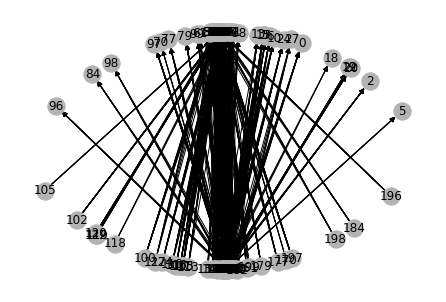

In [28]:
model = Model(10, 20, 5, hetero_graph.etypes)
import networkx as nx
nx_G = dgl.to_homogeneous(ratings).to_networkx()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
user_feats = hetero_graph.nodes['user'].data['feat']
item_feats = hetero_graph.nodes['menuItem'].data['feat']
label = hetero_graph.edges['rating'].data['label']
node_features = {'user': user_feats, 'menuItem': item_feats}

In [29]:
import dgl.function as fn
opt = torch.optim.Adam(model.parameters())
all_logits = []
for epoch in range(1000):
    pred = model(ratings, node_features, 'rating')
    loss = ((pred - label) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print('In epoch {}, loss: {}'.format(epoch, loss))
        all_logits.append(['{} {}'.format(epoch, loss)])
    #print(loss.item())

In epoch 0, loss: 1.3583855628967285
In epoch 5, loss: 1.3318270444869995
In epoch 10, loss: 1.3066705465316772
In epoch 15, loss: 1.2829225063323975
In epoch 20, loss: 1.2605705261230469
In epoch 25, loss: 1.2396080493927002
In epoch 30, loss: 1.2200064659118652
In epoch 35, loss: 1.2017122507095337
In epoch 40, loss: 1.184658169746399
In epoch 45, loss: 1.1687736511230469
In epoch 50, loss: 1.1539870500564575
In epoch 55, loss: 1.140228271484375
In epoch 60, loss: 1.1274300813674927
In epoch 65, loss: 1.1155295372009277
In epoch 70, loss: 1.1044660806655884
In epoch 75, loss: 1.094183087348938
In epoch 80, loss: 1.0846270322799683
In epoch 85, loss: 1.075748085975647
In epoch 90, loss: 1.0674993991851807
In epoch 95, loss: 1.0598376989364624
In epoch 100, loss: 1.0527225732803345
In epoch 105, loss: 1.046115756034851
In epoch 110, loss: 1.0399826765060425
In epoch 115, loss: 1.034290075302124
In epoch 120, loss: 1.0290077924728394
In epoch 125, loss: 1.0241070985794067
In epoch 130, 

In [15]:
from plotnine import *
import matplotlib.pyplot as plt
import pandas as pd
def linkPredGraph(all_logits):
    df = pd.DataFrame(all_logits) 
    df[['epoch','loss']] = df[0].str.split(expand=True) 
    del df[0]
    df.epoch = df.epoch.astype(float)
    df.loss = df.loss.astype(float)
    g = ggplot(df, aes(x='epoch', y='loss')) + geom_line() + labs(title = "loss per epoch") + geom_point(df)
    g.draw()

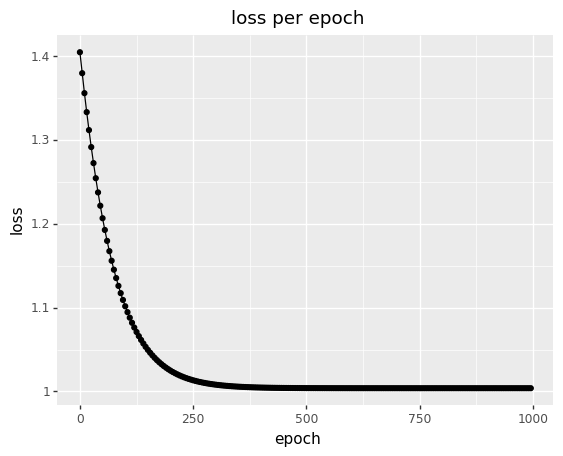

In [16]:
linkPredGraph(all_logits)